<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/free_poly/free_polynomial_monster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
%matplotlib inline

In [159]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interactive, BoundedIntText, BoundedFloatText
from tqdm.auto import tqdm
import cvxpy as cp
from functools import partial

In [160]:
dpi = 125
px = 1 / dpi
figsize = (640 * px, 480 * px)
double_figsize = (1280 * px, 480 * px)

mpl.rcParams['figure.dpi'] = dpi
mpl.rcParams['figure.figsize'] = figsize

# Function fitting

In [161]:
def func(x):
    z = np.cos(np.pi * x - 1) + 0.1 * np.cos(2 * np.pi * x + 1)
    return np.cbrt(np.abs(z)) * np.sign(z)

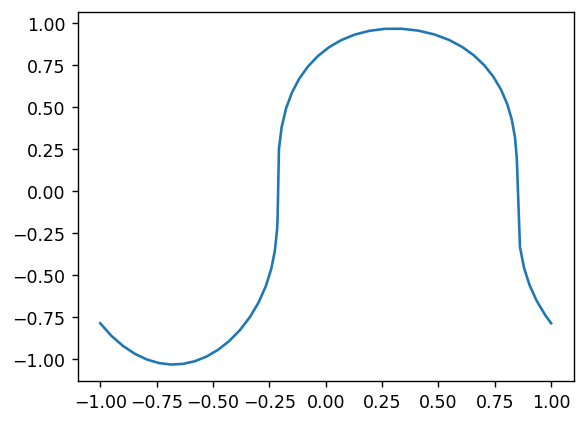

In [162]:
plot_xs = np.linspace(-1, 1, 1000)
plt.plot(plot_xs, func(plot_xs))
plt.show()

In [163]:
def noisy_func(x, noise=0.1):
    return func(x) + noise * np.random.randn(len(x))

In [164]:
np.random.seed(42)
n = 50
x = 2 * np.random.rand(n) - 1
y = noisy_func(x)

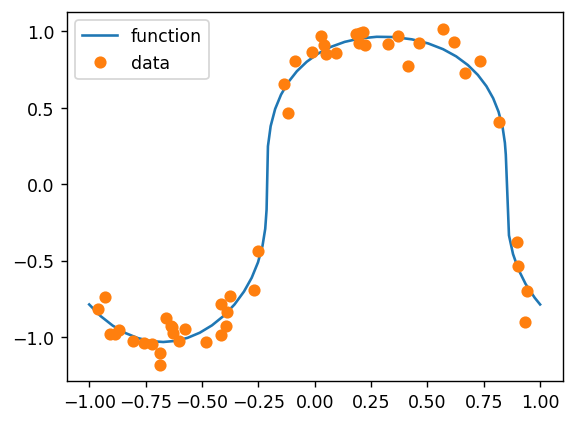

In [165]:
plt.plot(plot_xs, func(plot_xs), label='function')
plt.plot(x, y, 'o', label='data')
plt.legend()
plt.show()

In [166]:
def fit(degree, feature_matrix_fn):
    X = feature_matrix_fn(x, degree)
    poly = np.linalg.lstsq(X, y, rcond=-1)[0]
    train_rmse = np.sqrt(np.mean(np.square(X @ poly - y)))
    return poly, train_rmse


def test_fit(degree, feature_matrix_fn, coefs):
    xtest = np.linspace(-1, 1, 10000)
    ytest = feature_matrix_fn(xtest, degree) @ coefs
    test_rmse = np.sqrt(np.mean(np.square(ytest - func(xtest))))
    return xtest, ytest, test_rmse

In [167]:
def fit_cp(degree, feature_matrix_fn, bound):
    X = feature_matrix_fn(x, degree)
    poly = cp.Variable(degree + 1)
    obj = cp.Minimize(cp.norm(X @ poly - y, 2))
    prob = cp.Problem(obj, constraints=[
        cp.sum(poly) >= bound
    ])
    prob.solve()
    train_rmse = np.sqrt(np.mean(np.square(X @ poly.value - y)))
    return poly.value, train_rmse

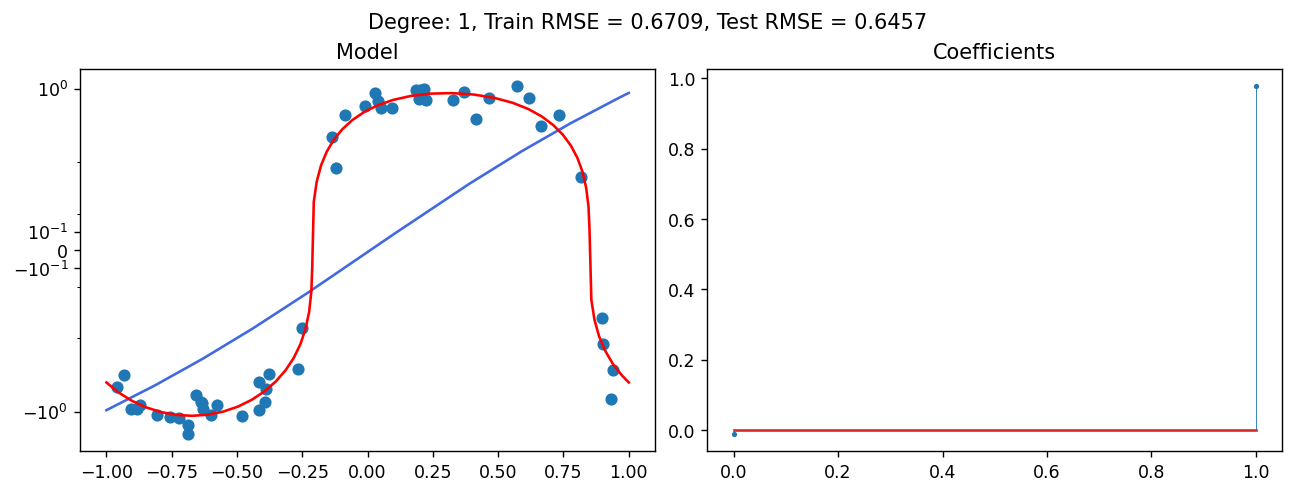

In [168]:
def fit_and_plot(degree, feature_matrix_fn):
    poly, train_rmse = fit(degree, feature_matrix_fn)
    xtest, ytest, test_rmse = test_fit(degree, feature_matrix_fn, poly)
    fig, axs = plt.subplots(1, 2, figsize=double_figsize, layout='constrained')
    fig.suptitle(f'Degree: {degree}, Train RMSE = {train_rmse:.4g}, Test RMSE = {test_rmse:.4g}')

    axs[0].scatter(x, y)
    axs[0].plot(xtest, ytest, color='royalblue')
    axs[0].plot(xtest, func(xtest), color='red')
    axs[0].set_yscale('asinh')
    axs[0].set_title('Model')

    markerline, stemlines, baseline = axs[1].stem(poly)
    stemlines.set_linewidth(0.5)
    markerline.set_markersize(2)
    axs[1].set_title('Coefficients')
    plt.show()

fit_and_plot(1, np.polynomial.polynomial.polyvander)

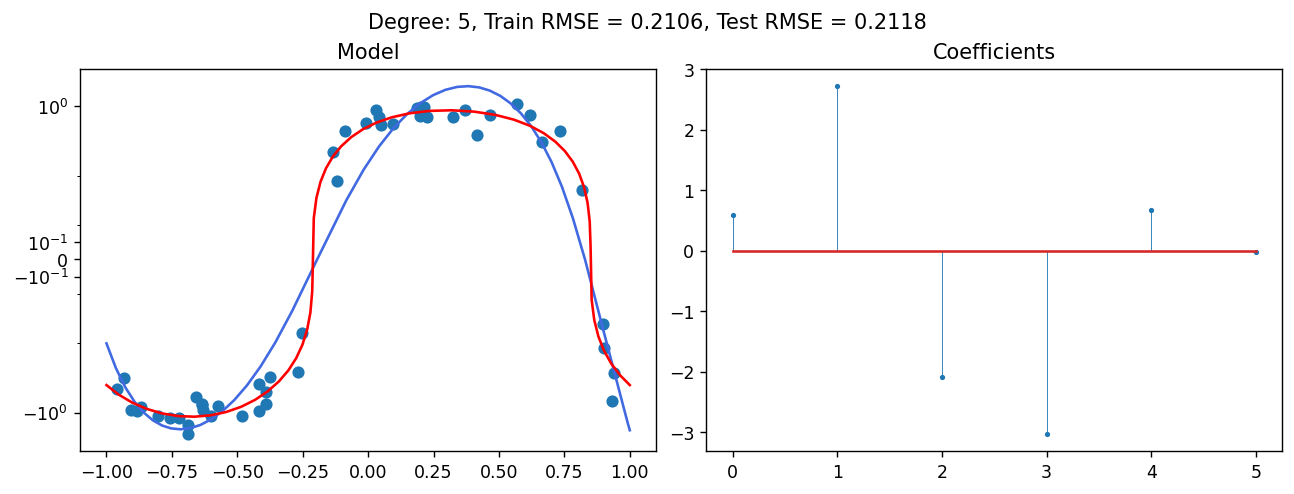

In [169]:
fit_and_plot(5, np.polynomial.polynomial.polyvander)

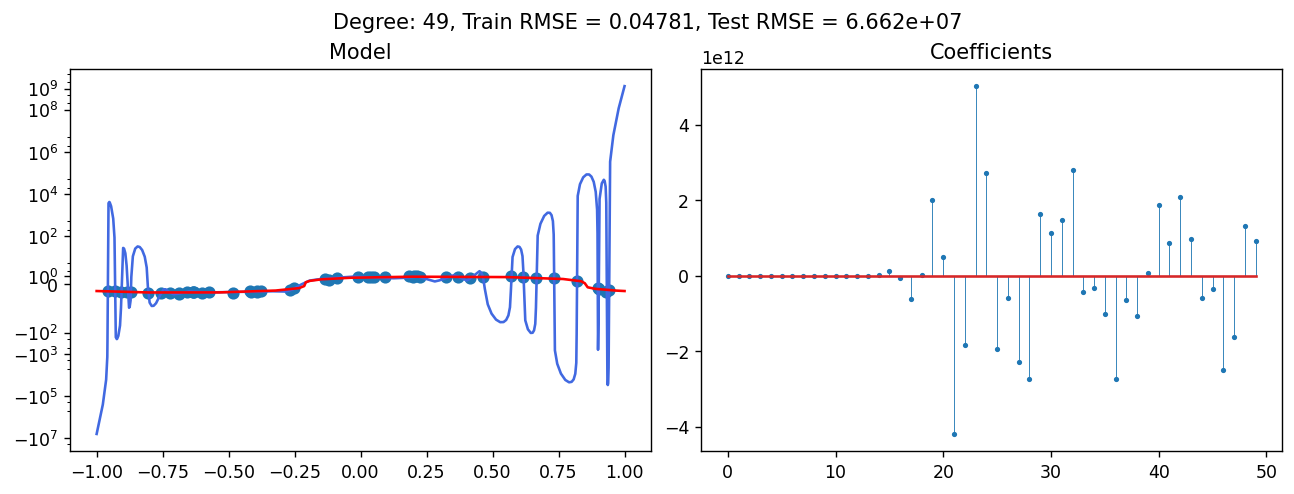

In [170]:
fit_and_plot(49, np.polynomial.polynomial.polyvander)

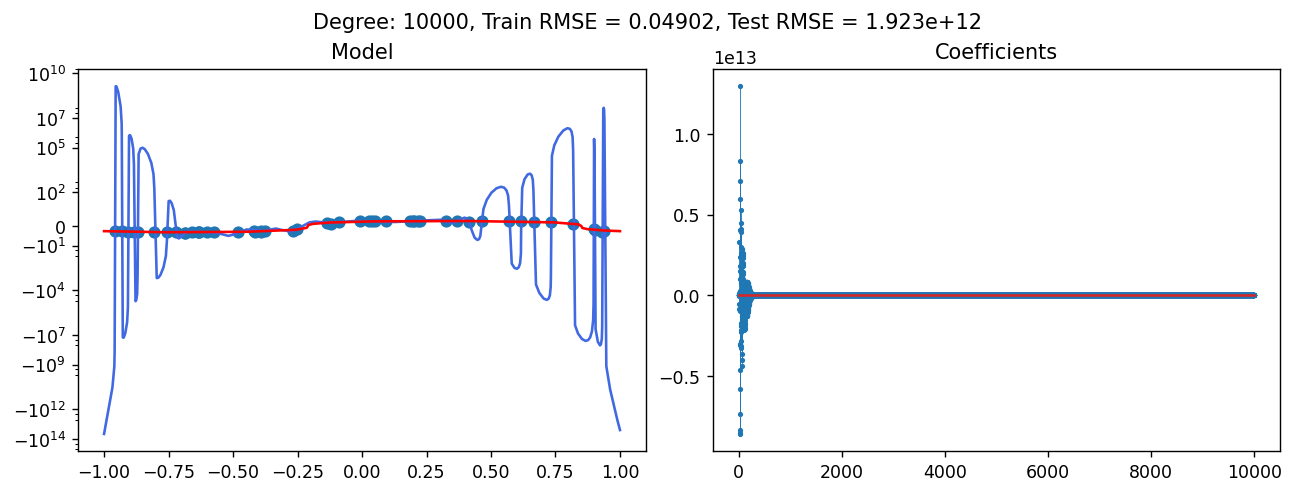

In [171]:
fit_and_plot(10000, np.polynomial.polynomial.polyvander)

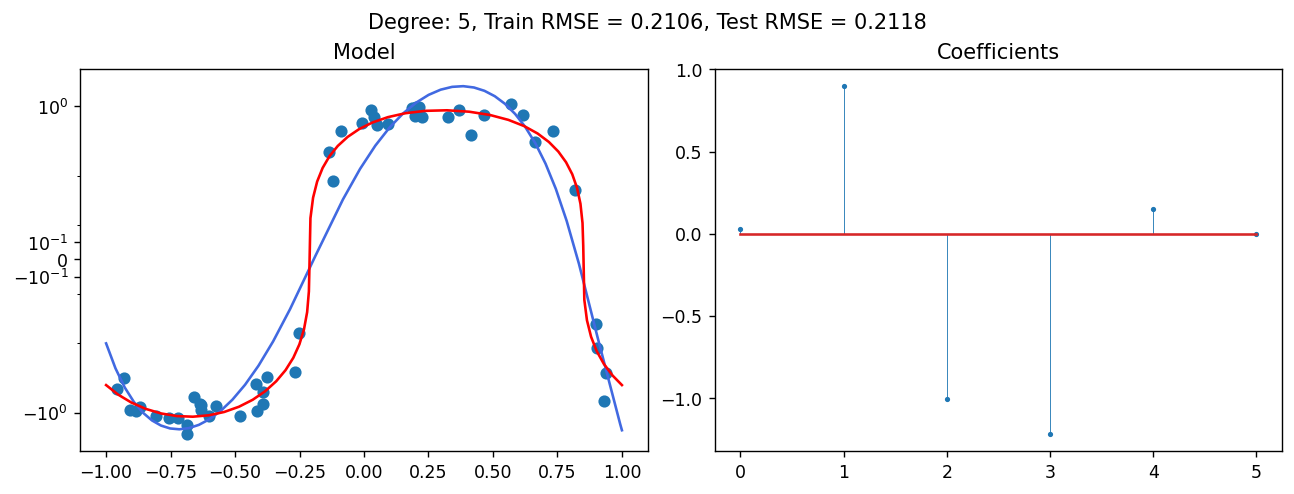

In [172]:
fit_and_plot(5, np.polynomial.legendre.legvander)

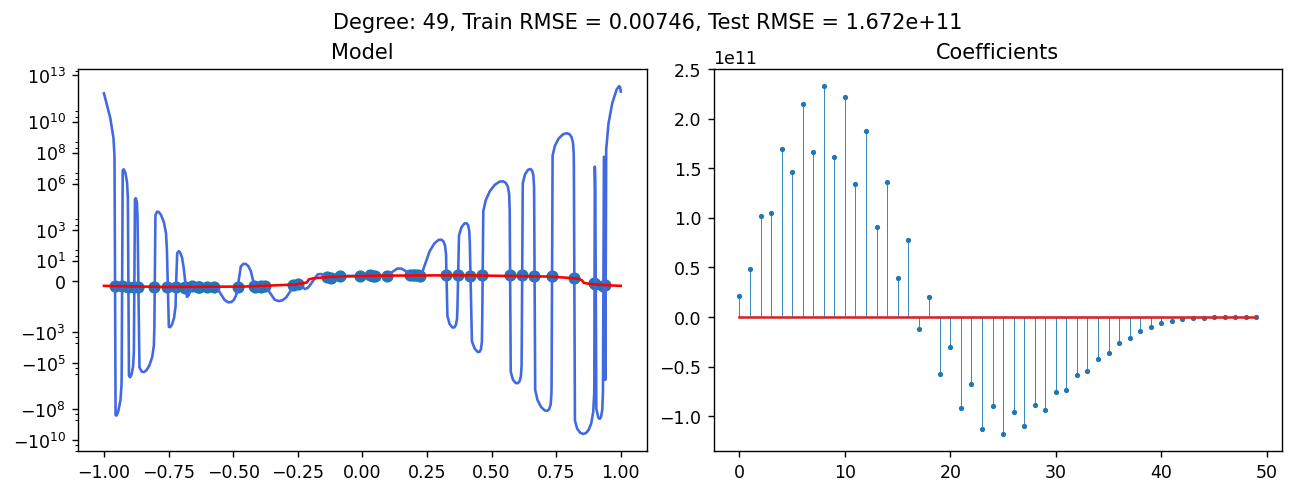

In [173]:
fit_and_plot(49, np.polynomial.legendre.legvander)

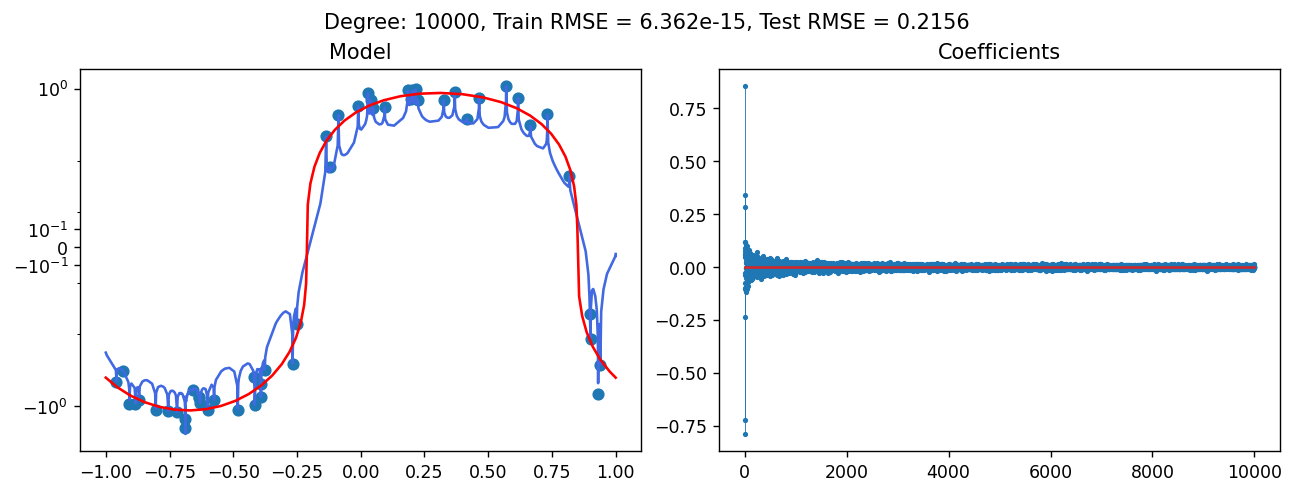

In [174]:
fit_and_plot(10000, np.polynomial.legendre.legvander)

# Error curves

In [175]:
def plot_errors(feature_matrix_fn):
    # define a set of degrees that look nice in a plot - linearly spaced
    # low degrees, and geometrically spaced high degrees.
    degs = np.r_[
        np.sort(np.unique(np.linspace(1, n - 1, 15).astype(int))),
        np.sort(np.unique(np.geomspace(n+1, 100000, 20).astype(int)))
    ]

    # compute train and test errors
    train_errors = np.zeros_like(degs).astype(float)
    test_errors = np.zeros_like(degs).astype(float)
    for i, deg in enumerate(tqdm(degs)):
        poly, train_errors[i] = fit(deg, feature_matrix_fn)
        _, _, test_errors[i] = test_fit(deg, feature_matrix_fn, poly)

    # plot the train and test errors, and the interpolation threshold vertical
    # bar.
    plt.figure(figsize=double_figsize, layout='constrained')
    plt.plot(degs, train_errors, label='Train')
    plt.plot(degs, test_errors, label='Test')
    plt.axvline(n - 1, color='royalblue', linewidth=3, linestyle='dotted',
                alpha=0.5)
    plt.axhline(np.min(test_errors), color='olive', linewidth=1, linestyle='dashed',
                alpha=0.5, label=f'Min RMSE = {np.min(test_errors):.3g}')
    plt.ylim([-1e-3, 2 * np.max(test_errors)])
    plt.yscale('asinh', linear_width=1e-3)
    plt.xscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

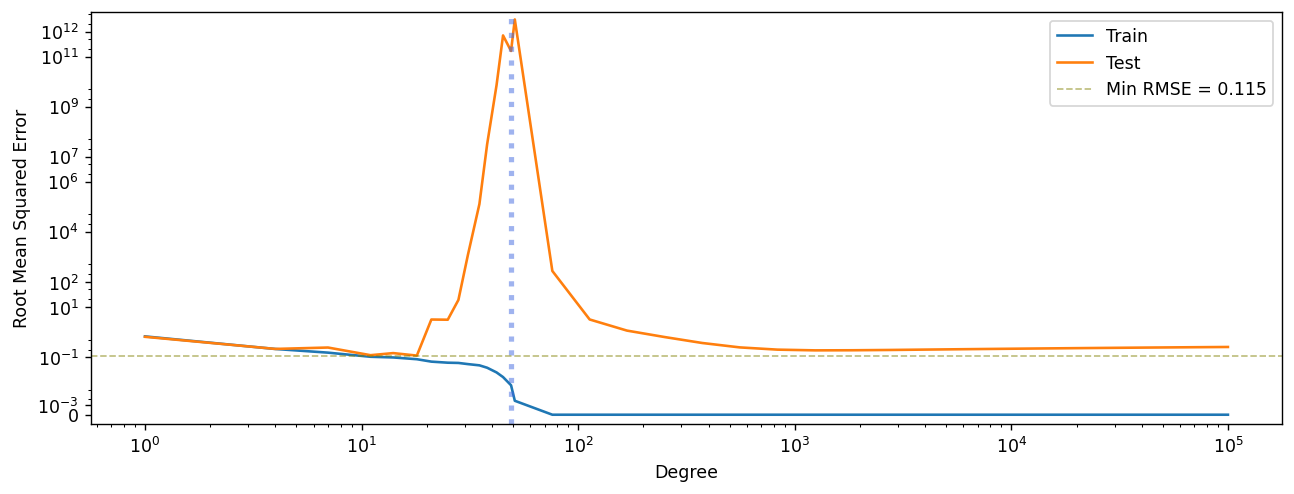

In [176]:
plot_errors(np.polynomial.legendre.legvander)

  0%|          | 0/35 [00:00<?, ?it/s]

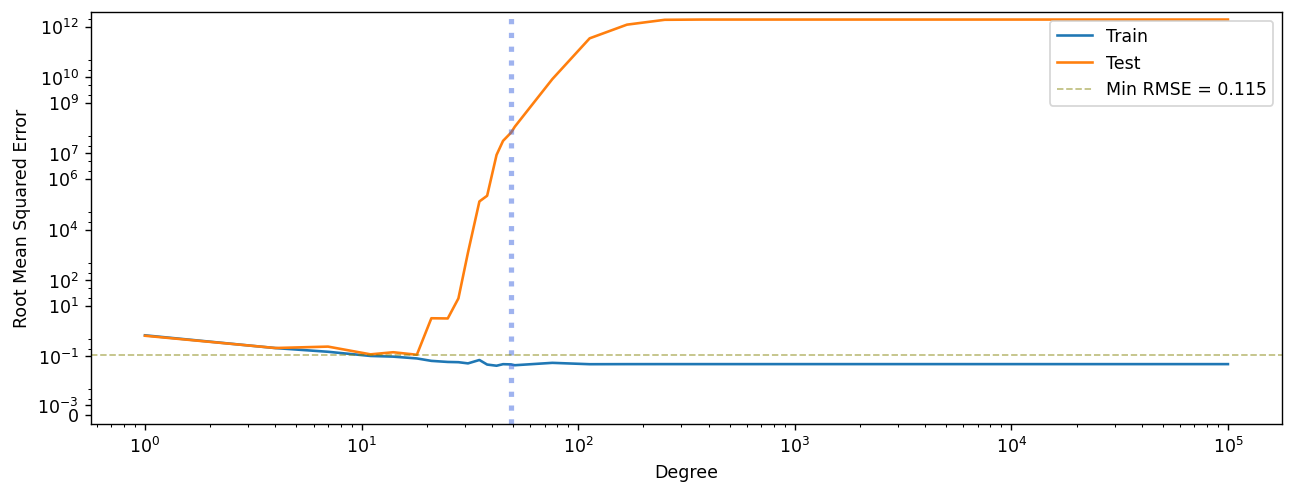

In [177]:
plot_errors(np.polynomial.polynomial.polyvander)

# Orthogonality

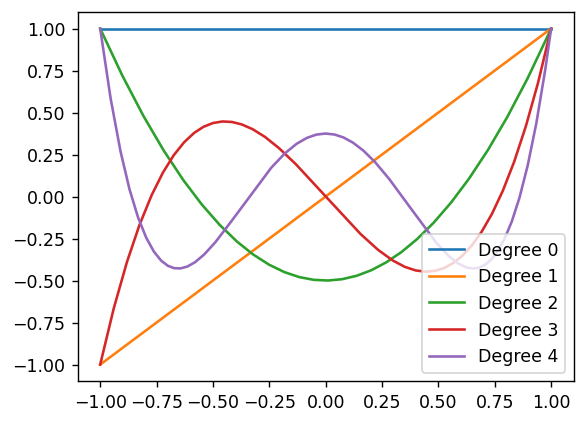

In [178]:
handles = plt.plot(plot_xs, np.polynomial.legendre.legvander(plot_xs, 4))
plt.legend(handles=handles, labels=[f'Degree {i}' for i in range(5)])
plt.show()

# Extrapolation

In [189]:
np.random.seed(42)
n = 25
x = np.random.rand(n) - 0.5
y = noisy_func(x)

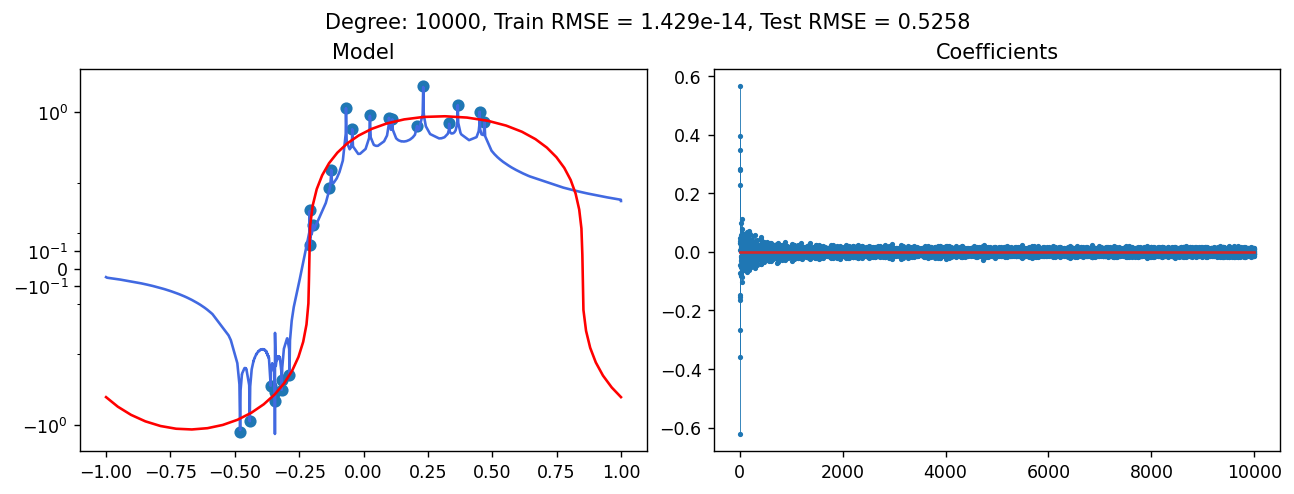

In [192]:
fit_and_plot(10000, np.polynomial.legendre.legvander)